In [124]:
import warnings
warnings.filterwarnings('ignore')

import numpy
import matplotlib.pyplot as plt
import glob

import pandas as pd
#from bokeh.charts import TimeSeries, show, output_file

import iris
from iris.experimental.equalise_cubes import equalise_attributes

####

import os, sys

cwd = os.getcwd()
repo_dir = '/'
for directory in cwd.split('/')[1:]:
    repo_dir = os.path.join(repo_dir, directory)
    if directory == 'ocean-analysis':
        break

modules_dir = os.path.join(repo_dir, 'modules')
sys.path.append(modules_dir)

processing_dir = os.path.join(repo_dir, 'data_processing')
sys.path.append(processing_dir)

import timeseries
import remove_drift

## Read data

In [125]:
# Configuration
model = 'NorESM1-M'
experiment = 'historical'
rip = 'r1i1p1'
ua6_dir = '/g/data/ua6/DRSv3/CMIP5'  # /g/data/r87/dbi599
r87_dir = '/g/data/r87/dbi599/DRSv2/CMIP5'

depth_index = 0
i_index = 34
j_index = 50

#lev_constraint = iris.Constraint(lev=depth)
#lat_constraint = iris.Constraint(lat=latitude)
#lon_constraint = iris.Constraint(lon=longitude)

In [126]:
control_files = glob.glob('%s/%s/piControl/mon/ocean/r1i1p1/thetao/latest/thetao_Omon_%s_piControl_r1i1p1_*.nc' %(ua6_dir, model, model) )
experiment_files = glob.glob('%s/%s/%s/mon/ocean/%s/thetao/latest/thetao_Omon_%s_%s_%s_*.nc' %(ua6_dir, model, experiment, rip, model, experiment, rip) )
dedrifted_files = glob.glob('%s/%s/%s/yr/ocean/%s/thetao/latest/dedrifted/thetao_Oyr_%s_%s_%s_??????-??????.nc' %(r87_dir, model, experiment, rip, model, experiment, rip) )
coefficient_file = '%s/%s/piControl/yr/ocean/r1i1p1/thetao/latest/thetao-coefficients_Oyr_%s_piControl_r1i1p1_all.nc' %(r87_dir, model, model)

control_files.sort()
experiment_files.sort()
dedrifted_files.sort()

In [127]:
def read_files(file_list, depth_index, i_index, j_index):
    """Read a list of files into an iris Cube"""
    
    cube = iris.load(file_list, 'sea_water_potential_temperature')
    iris.util.unify_time_units(cube)
    equalise_attributes(cube)
    cube = cube.concatenate_cube()[:, depth_index, i_index, j_index]
    
    return cube

In [128]:
control_cube = read_files(control_files, depth_index, i_index, j_index)
control_cube = timeseries.convert_to_annual(control_cube)

In [129]:
experiment_cube = read_files(experiment_files, depth_index, i_index, j_index)
experiment_cube = timeseries.convert_to_annual(experiment_cube)

In [130]:
dedrifted_cube = read_files(dedrifted_files, depth_index, i_index, j_index)

In [131]:
a_cube = iris.load_cube(coefficient_file, 'coefficient a')[depth_index, i_index, j_index]
b_cube = iris.load_cube(coefficient_file, 'coefficient b')[depth_index, i_index, j_index]
c_cube = iris.load_cube(coefficient_file, 'coefficient c')[depth_index, i_index, j_index]
d_cube = iris.load_cube(coefficient_file, 'coefficient d')[depth_index, i_index, j_index]

In [132]:
numpy_poly = numpy.poly1d([float(d_cube.data), 
                           float(c_cube.data),
                           float(b_cube.data),
                           float(a_cube.data)])
cubic_fit = numpy_poly(control_cube.coord('time').points)

In [133]:
first_data_cube = iris.load_cube(experiment_files[0], 'sea_water_potential_temperature')[:, depth_index, i_index, j_index]
first_data_cube = timeseries.convert_to_annual(first_data_cube)
time_diff, branch_time, new_time_unit = remove_drift.time_adjustment(first_data_cube, a_cube, 'annual')

In [134]:
time_coord = experiment_cube.coord('time')
time_coord.convert_units(new_time_unit)
experiment_time_values = time_coord.points.astype(numpy.float32) - time_diff

## Plot

In [135]:
%matplotlib inline

In [136]:
#control_times = control_cube.coord('time').points
#df = pd.DataFrame(control_cube.data, index=control_times, columns=['control'])

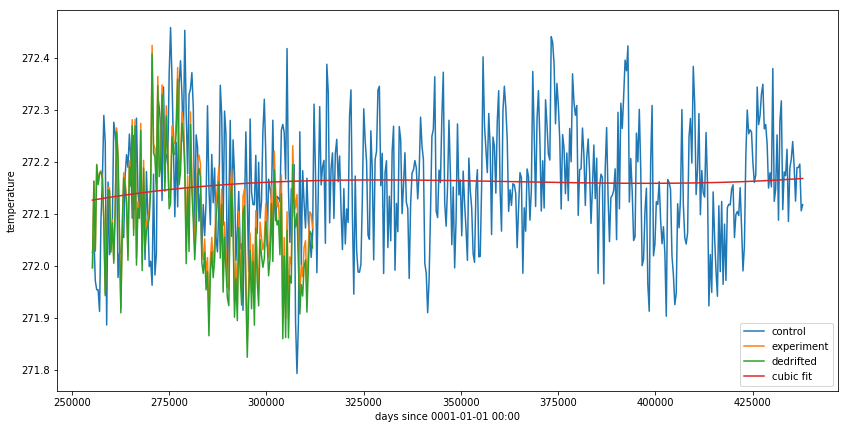

In [142]:
fig = plt.figure(figsize=[14, 7])
plt.plot(control_cube.coord('time').points, control_cube.data, label='control')
plt.plot(experiment_time_values, experiment_cube.data, label='experiment')
plt.plot(experiment_time_values, dedrifted_cube.data, label='dedrifted')
plt.plot(control_cube.coord('time').points, cubic_fit, label='cubic fit')
plt.ylabel('temperature')
plt.xlabel(str(new_time_unit))

plt.legend()
plt.show()

In [141]:
str(new_time_unit)

'days since 0001-01-01 00:00'